In [ ]:
#compute the best asset allocation with fixed trigger, the flaw is annual relanace
# dont know how is it done

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Historical return & volatility for each NPS asset class (in %)
asset_classes = {
    "Equity (E)": {"mean": 12, "std": 18}, 
    "Corporate Bonds (C)": {"mean": 8, "std": 6},  
    "Govt Securities (G)": {"mean": 6, "std": 4},  
    "Alternative (A)": {"mean": 10, "std": 12}  
}

# Investment parameters
investment_years = 30  
simulations = 1000  
initial_investment = 10_00_000  # Initial corpus
monthly_contribution = 10_000  # Monthly NPS contribution
annual_growth_rate = 0.10  # 10% increase in contribution per year
months_per_year = 12  

# Define allocation constraints (NPS Active Choice Limits)
max_equity = 70  # Max 50% in Equity for Tier 1 NPS
max_bonds = 100
max_govt_sec = 100
max_alternatives = 5

# Different rebalancing triggers to test
rebalance_triggers = {
    "No Rebalancing": None,
    "Annual Rebalancing": 1,
    "Biannual Rebalancing": 2,
    "Drift > 5%": 0.05,
    "Drift > 10%": 0.10
}

# Seed for reproducibility
np.random.seed(42)

# Store results for different rebalancing strategies
strategy_results = {}

for strategy, rebalance_rule in rebalance_triggers.items():
    final_returns = []
    
    for _ in range(simulations):
        # Generate a random allocation within constraints
        eq = np.random.uniform(0, max_equity)
        cb = np.random.uniform(0, max_bonds)
        gs = np.random.uniform(0, max_govt_sec)
        al = np.random.uniform(0, max_alternatives)

        # Normalize to 100%
        total = eq + cb + gs + al
        eq, cb, gs, al = eq / total, cb / total, gs / total, al / total
        target_allocation = np.array([eq, cb, gs, al])  
        
        portfolio_value = initial_investment
        portfolio_allocations = target_allocation.copy()
        current_monthly_contribution = monthly_contribution
        
        for year in range(investment_years):
            for month in range(months_per_year):
                # Generate monthly returns for each asset
                monthly_returns = np.array([
                    np.random.normal(asset_classes["Equity (E)"]["mean"] / 12, asset_classes["Equity (E)"]["std"] / np.sqrt(12)),
                    np.random.normal(asset_classes["Corporate Bonds (C)"]["mean"] / 12, asset_classes["Corporate Bonds (C)"]["std"] / np.sqrt(12)),
                    np.random.normal(asset_classes["Govt Securities (G)"]["mean"] / 12, asset_classes["Govt Securities (G)"]["std"] / np.sqrt(12)),
                    np.random.normal(asset_classes["Alternative (A)"]["mean"] / 12, asset_classes["Alternative (A)"]["std"] / np.sqrt(12))
                ])

                # Apply returns to portfolio
                portfolio_value *= (1 + np.dot(portfolio_allocations, monthly_returns) / 100)

                # Add monthly contribution
                portfolio_value += current_monthly_contribution

                # Compute new allocation after growth
                asset_values = portfolio_value * portfolio_allocations
                new_allocations = asset_values / asset_values.sum()

                # Rebalancing logic
                if rebalance_rule is None:
                    pass  # No rebalancing
                elif isinstance(rebalance_rule, int) and year % rebalance_rule == 0 and month == 11:
                    portfolio_allocations = target_allocation.copy()  # Time-based rebalancing
                elif isinstance(rebalance_rule, float) and month == 11:
                    drift = new_allocations - target_allocation
                    if np.any(np.abs(drift) > rebalance_rule):  
                        portfolio_allocations = target_allocation.copy()  # Drift-based rebalancing

            # Increase monthly contribution by 10% annually
            current_monthly_contribution *= (1 + annual_growth_rate)

        final_returns.append(portfolio_value)

    strategy_results[strategy] = final_returns

# Convert to DataFrame for analysis
results_df = pd.DataFrame(strategy_results)
print(results_df)
# Find the best rebalancing strategy
best_strategy = results_df.mean().idxmax()
best_mean_return = results_df[best_strategy].mean()

print(f"\nBest Rebalancing Strategy: {best_strategy}")
print(f"Expected Portfolio Value: ₹{best_mean_return:,.2f}")

# Plot the distribution of final corpus values for different strategies
plt.figure(figsize=(12, 6))
for strategy in strategy_results.keys():
    plt.hist(results_df[strategy], bins=50, alpha=0.5, label=strategy)

plt.axvline(best_mean_return, color='red', linestyle='dashed', linewidth=2, label="Best Strategy")
plt.xlabel("Final Portfolio Value (₹)")
plt.ylabel("Frequency")
plt.title("Monte Carlo Simulation: Final Corpus Distribution Across Rebalancing Strategies")
plt.legend()
plt.show()


In [ ]:
#compute the impact of top-up on dips

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulation parameters
years = 30
months = years * 12
monthly_contribution = 10000  # ₹10k per month
annual_increase = 1.1  # 10% yearly increase
market_dip_threshold = -0.05  # Dip defined as -2% monthly return
top_up_amount = 10000  # Extra ₹10k per dip

# Simulated monthly returns (Equity-heavy NPS)
mean_return = 0.008  # Avg monthly return ~9.6% annualized
volatility = 0.05  # Market volatility

# Running Monte Carlo Simulations
simulations = 10000
results_without_topup = []
results_with_topup = []

for _ in range(simulations):
    corpus_without_topup = 0
    corpus_with_topup = 0
    monthly_contribution_dynamic = monthly_contribution  # Contribution increases yearly

    for month in range(months):
        # Simulate market return
        market_return = np.random.normal(mean_return, volatility)

        # Without Top-Up: Regular contribution
        corpus_without_topup = corpus_without_topup * (1 + market_return) + monthly_contribution_dynamic

        # With Top-Up: Extra ₹10k investment during dips
        if market_return < market_dip_threshold:
            corpus_with_topup += top_up_amount  # Extra investment

        corpus_with_topup = corpus_with_topup * (1 + market_return) + monthly_contribution_dynamic

        # Increase monthly contribution annually
        if month % 12 == 0:
            monthly_contribution_dynamic *= annual_increase

    results_without_topup.append(corpus_without_topup)
    results_with_topup.append(corpus_with_topup)

# Convert to DataFrame
results_df = pd.DataFrame({
    "Without Top-Up": results_without_topup,
    "With Top-Up": results_with_topup
})

# Calculate mean corpus for both strategies
mean_without_topup = results_df["Without Top-Up"].mean()
mean_with_topup = results_df["With Top-Up"].mean()

print(f"Final Corpus Without Top-Up: ₹{mean_without_topup/1e7:.2f} Cr")
print(f"Final Corpus With Top-Up: ₹{mean_with_topup/1e7:.2f} Cr")

# Visualization
plt.figure(figsize=(12, 5))

# Histogram Without Top-Up
plt.subplot(1, 2, 1)
plt.hist(results_df["Without Top-Up"], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(mean_without_topup, color='red', linestyle='dashed', linewidth=2)
plt.title("Final Corpus Without Top-Up")
plt.xlabel("Corpus (₹)")
plt.ylabel("Frequency")

# Histogram With Top-Up
plt.subplot(1, 2, 2)
plt.hist(results_df["With Top-Up"], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.axvline(mean_with_topup, color='red', linestyle='dashed', linewidth=2)
plt.title("Final Corpus With Top-Up")
plt.xlabel("Corpus (₹)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
#optimize allocation based on deviation

import random

def generate_returns(allocation, years=30, simulations=10000):
    """
    Simulates NPS returns for given asset allocation using Monte Carlo method.
    """
    asset_classes = {
        'Equity': (0.12, 0.20),  # Mean return 12%, volatility 20%
        'Corporate Bonds': (0.08, 0.10),
        'Government Bonds': (0.06, 0.05),
        'Alternative Assets': (0.10, 0.15)
    }
    
    final_values = []
    for _ in range(simulations):
        value = 0
        annual_contribution = 100000  # Starting annual contribution
        for year in range(1, years + 1):
            yearly_return = sum(
                allocation[asset] * (random.uniform(asset_classes[asset][0] - asset_classes[asset][1],
                                      asset_classes[asset][0] + asset_classes[asset][1]))
                for asset in allocation)
            value += annual_contribution
            value *= (1 + yearly_return)
            if year % 10 == 0:  # Increase contribution by 10% every 10 years
                annual_contribution *= 1.10
        final_values.append(value)
    return final_values

def optimize_allocation():
    """
    Finds the best asset allocation to maximize returns using Monte Carlo simulation.
    """
    best_allocation = None
    best_median_return = 0
    for _ in range(100):  # Try 100 different allocations
        allocation = {
            'Equity': random.uniform(0.2, 0.75),
            'Corporate Bonds': random.uniform(0.05, 0.4),
            'Government Bonds': random.uniform(0.05, 0.4),
            'Alternative Assets': random.uniform(0, 0.2)
        }
        total = sum(allocation.values())
        for key in allocation:
            allocation[key] /= total  # Normalize to ensure sum is 1
        returns = generate_returns(allocation)
        median_return = sorted(returns)[len(returns) // 2]
        if median_return > best_median_return:
            best_median_return = median_return
            best_allocation = allocation
    return best_allocation, best_median_return

def rebalance_portfolio(allocation, years=30, threshold=0.05):
    """
    Adjusts the allocation based on performance deviation.
    """
    for year in range(1, years + 1):
        simulated_returns = generate_returns(allocation, years=1, simulations=1000)
        median_return = sorted(simulated_returns)[len(simulated_returns) // 2]
        if median_return < threshold:
            allocation, _ = optimize_allocation()
            print(f"Rebalanced in Year {year}: {allocation}")
    return allocation

def estimate_final_corpus():
    """
    Estimates the final corpus based on the best allocation strategy.
    """
    best_allocation, best_return = optimize_allocation()
    final_corpus = sum(generate_returns(best_allocation, simulations=1000)) / 1000
    return best_allocation, final_corpus

if __name__ == "__main__":
    best_strategy, expected_corpus = estimate_final_corpus()
    print(f"Best Asset Allocation: {best_strategy}")
    print(f"Expected Final Corpus: {expected_corpus:.2f}")


In [ ]:
#compute the impact of top-up on final corpus

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulation parameters
years = 30
months = years * 12
monthly_contribution = 10000  # ₹10k per month
annual_increase = 1.1  # 10% yearly increase
market_dip_threshold = -0.05  # Dip defined as -5% monthly return
top_up_amount = 10000  # Extra ₹10k per dip

# Simulated monthly returns (Equity-heavy NPS)
mean_return = 0.008  # Avg monthly return ~9.6% annualized
volatility = 0.05  # Market volatility

# Running Monte Carlo Simulations
simulations = 10000
results_without_topup = []
results_with_topup = []
total_topup_list = []
topup_return_list = []

for _ in range(simulations):
    corpus_without_topup = 0
    corpus_with_topup = 0
    monthly_contribution_dynamic = monthly_contribution  # Contribution increases yearly
    total_topup = 0  # Track total top-up amount

    for month in range(months):
        # Simulate market return
        market_return = np.random.normal(mean_return, volatility)

        # Without Top-Up: Regular contribution
        corpus_without_topup = corpus_without_topup * (1 + market_return) + monthly_contribution_dynamic

        # With Top-Up: Extra ₹10k investment during dips
        if market_return < market_dip_threshold:
            corpus_with_topup += top_up_amount  # Extra investment
            total_topup += top_up_amount  # Track total amount invested via top-ups

        corpus_with_topup = corpus_with_topup * (1 + market_return) + monthly_contribution_dynamic

        # Increase monthly contribution annually
        if month % 12 == 0:
            monthly_contribution_dynamic *= annual_increase

    results_without_topup.append(corpus_without_topup)
    results_with_topup.append(corpus_with_topup)
    total_topup_list.append(total_topup)
    topup_return_list.append(corpus_with_topup - corpus_without_topup)  # Extra corpus generated from top-ups

# Convert to DataFrame
results_df = pd.DataFrame({
    "Without Top-Up": results_without_topup,
    "With Top-Up": results_with_topup,
    "Total Top-Up Invested": total_topup_list,
    "Top-Up Returns": topup_return_list
})

# Calculate means
mean_without_topup = results_df["Without Top-Up"].mean()
mean_with_topup = results_df["With Top-Up"].mean()
mean_total_topup = results_df["Total Top-Up Invested"].mean()
mean_topup_returns = results_df["Top-Up Returns"].mean()

print(f"Final Corpus Without Top-Up: ₹{mean_without_topup/1e7:.2f} Cr")
print(f"Final Corpus With Top-Up: ₹{mean_with_topup/1e7:.2f} Cr")
print(f"Total Top-Up Invested: ₹{mean_total_topup/1e6:.2f} Lakh")
print(f"Extra Returns from Top-Up: ₹{mean_topup_returns/1e6:.2f} Lakh")

# Visualization
plt.figure(figsize=(12, 6))

# Histogram of Final Corpus (Without & With Top-Up)
plt.subplot(1, 2, 1)
plt.hist(results_df["Without Top-Up"], bins=50, alpha=0.7, color='blue', edgecolor='black', label="Without Top-Up")
plt.hist(results_df["With Top-Up"], bins=50, alpha=0.7, color='green', edgecolor='black', label="With Top-Up")
plt.axvline(mean_without_topup, color='red', linestyle='dashed', linewidth=2, label="Avg Without Top-Up")
plt.axvline(mean_with_topup, color='purple', linestyle='dashed', linewidth=2, label="Avg With Top-Up")
plt.title("Final Corpus Distribution")
plt.xlabel("Corpus (₹)")
plt.ylabel("Frequency")
plt.legend()

# Histogram of Top-Up Returns
plt.subplot(1, 2, 2)
plt.hist(results_df["Top-Up Returns"], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(mean_topup_returns, color='red', linestyle='dashed', linewidth=2, label="Avg Extra Returns")
plt.title("Extra Returns Due to Top-Up")
plt.xlabel("Extra Corpus from Top-Up (₹)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
''' statically check the best allocation strategy and top-up impact
ideally, every time you change allocation say based on dip, top-up should be done.
meaning allocation change & top-up are together not independent of each other.
this we will test in the part cell
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Simulation Parameters
years = 30
months = years * 12
monthly_contribution = 10000  # ₹10k per month
annual_increase = 1.1  # 10% yearly increase
top_up_base = 10000  # Top-up base amount
dip_levels = [-0.03, -0.05, -0.07, -0.10]  # Dip thresholds for top-up
top_up_multipliers = [1, 2, 3, 5]  # Multiplier for top-ups

# Asset Classes and Parameters
assets = ["Equity", "Bonds", "G-Secs", "Alt Assets"]
returns = {"Equity": 0.008, "Bonds": 0.005, "G-Secs": 0.004, "Alt Assets": 0.010}
volatility = {"Equity": 0.05, "Bonds": 0.02, "G-Secs": 0.01, "Alt Assets": 0.06}

# Simulation Parameters
simulations = 1000
allocation_steps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

# Generate possible asset allocation combinations (that sum to 1)
allocations = [
    list(allocation) for allocation in product(allocation_steps, repeat=4) if sum(allocation) == 1.0
]

best_corpus = 0
best_allocation = None
results_summary = []

# Run simulations for each asset allocation
for allocation in allocations:
    weights = dict(zip(assets, allocation))
    results_without_topup = []
    results_with_topup = []

    for _ in range(simulations):
        corpus_without_topup = 0
        corpus_with_topup = 0
        monthly_contribution_dynamic = monthly_contribution

        for month in range(months):
            # Simulate returns based on asset allocation
            total_return = sum(
                weights[asset] * np.random.normal(returns[asset], volatility[asset]) for asset in assets
            )

            # Without Top-Up
            corpus_without_topup = corpus_without_topup * (1 + total_return) + monthly_contribution_dynamic

            # With Top-Up: Check for dips and apply top-ups
            top_up_amount = 0
            for dip, multiplier in zip(dip_levels, top_up_multipliers):
                if total_return < dip:
                    top_up_amount = top_up_base * multiplier
                else:
                    break

            corpus_with_topup += top_up_amount
            corpus_with_topup = corpus_with_topup * (1 + total_return) + monthly_contribution_dynamic

            # Increase contribution annually
            if month % 12 == 0:
                monthly_contribution_dynamic *= annual_increase

        results_without_topup.append(corpus_without_topup)
        results_with_topup.append(corpus_with_topup)

    # Calculate mean corpus for this allocation
    mean_with_topup = np.mean(results_with_topup)
    results_summary.append((allocation, mean_with_topup))

    # Update best strategy if corpus is higher
    if mean_with_topup > best_corpus:
        best_corpus = mean_with_topup
        best_allocation = allocation

# Display best strategy
print(f"✅ Best Asset Allocation: {dict(zip(assets, best_allocation))}")
print(f"📈 Final Corpus with Optimal Allocation & Top-Up: ₹{best_corpus / 1e7:.2f} Cr")

# Visualizing Top 5 Allocations
top_results = sorted(results_summary, key=lambda x: x[1], reverse=True)[:5]
top_labels = [f"{dict(zip(assets, alloc))}" for alloc, _ in top_results]
top_corpus = [corpus / 1e7 for _, corpus in top_results]

plt.figure(figsize=(10, 6))
plt.barh(top_labels, top_corpus, color='skyblue')
plt.xlabel("Final Corpus (₹ Cr)")
plt.ylabel("Top 5 Asset Allocations")
plt.title("Top 5 Asset Allocations with Top-Up Impact")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
''' combine top up & dynamic allocation - this code didnt work, the logic was conflicting '''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Simulation Parameters
years = 30
months = years * 12
monthly_contribution = 10000  # ₹10k per month
annual_increase = 1.1  # 10% yearly increase
top_up_base = 10000  # Top-up base amount
dip_levels = [-0.03, -0.05, -0.07, -0.10]  # Dip thresholds
top_up_multipliers = [1, 2, 3, 5]  # Top-up multipliers

# Asset Classes and Parameters
assets = ["Equity", "Bonds", "G-Secs", "Alt Assets"]
returns = {"Equity": 0.008, "Bonds": 0.005, "G-Secs": 0.004, "Alt Assets": 0.010}
volatility = {"Equity": 0.05, "Bonds": 0.02, "G-Secs": 0.01, "Alt Assets": 0.06}

# NPS Allocation Limits (Active Choice)
nps_limits = {
    "Equity": (0, 0.75),
    "Bonds": (0, 1.0),
    "G-Secs": (0, 1.0),
    "Alt Assets": (0, 0.05),
}

# Monte Carlo Parameters
simulations = 1000
allocation_steps = [0.1, 0.2, 0.3, 0.4, 0.5]  # 10%, 20%, 30%, etc.

# Generate Valid Asset Allocations within NPS Limits
valid_allocations = []
for allocation in product(allocation_steps, repeat=4):
    if sum(allocation) == 1.0:
        within_limits = all(
            nps_limits[asset][0] <= allocation[i] <= nps_limits[asset][1]
            for i, asset in enumerate(assets)
        )
        if within_limits:
            valid_allocations.append(allocation)

# Track best strategy
best_corpus = 0
best_allocation = None
results_summary = []

# Run Baseline Simulation (No Top-Up / No Reallocation)
results_baseline = []

for _ in range(simulations):
    corpus_baseline = 0
    monthly_contribution_dynamic = monthly_contribution

    for month in range(months):
        # Fixed Baseline Allocation
        baseline_weights = {"Equity": 0.5, "Bonds": 0.3, "G-Secs": 0.15, "Alt Assets": 0.05}
        baseline_return = sum(
            baseline_weights[asset] * np.random.normal(returns[asset], volatility[asset])
            for asset in assets
        )
        corpus_baseline = corpus_baseline * (1 + baseline_return) + monthly_contribution_dynamic

        # Increase monthly contribution annually
        if month % 12 == 0:
            monthly_contribution_dynamic *= annual_increase

    results_baseline.append(corpus_baseline)

# Average Final Corpus for Baseline
mean_baseline = np.mean(results_baseline)
print(f"🏦 Final Corpus (Baseline without Top-Up/Rebalancing): ₹{mean_baseline / 1e7:.2f} Cr")

# Run Monte Carlo Simulation with Top-Up + Rebalancing
for allocation in valid_allocations:
    weights = dict(zip(assets, allocation))
    results_combined = []

    for _ in range(simulations):
        corpus_combined = 0
        monthly_contribution_dynamic = monthly_contribution
        total_top_up = 0
        top_up_roi = 0

        for month in range(months):
            # Simulate monthly market return based on asset allocation
            total_return = sum(
                weights[asset] * np.random.normal(returns[asset], volatility[asset])
                for asset in assets
            )

            # Top-Up Logic if Market Dips
            top_up_amount = 0
            rebalance_triggered = False

            for dip, multiplier in zip(dip_levels, top_up_multipliers):
                if total_return < dip:
                    top_up_amount = top_up_base * multiplier
                    rebalance_triggered = True
                    break

            corpus_combined += top_up_amount
            corpus_combined = corpus_combined * (1 + total_return) + monthly_contribution_dynamic

            # Track Total Top-Up and its ROI
            if top_up_amount > 0:
                total_top_up += top_up_amount
                top_up_roi += top_up_amount * (1 + total_return)

            # Rebalancing after a Dip if Triggered
            if rebalance_triggered:
                weights = {
                    "Equity": min(weights["Equity"] + 0.1, 0.75),
                    "Bonds": max(weights["Bonds"] - 0.05, 0.1),
                    "G-Secs": max(weights["G-Secs"] - 0.05, 0.1),
                    "Alt Assets": min(weights["Alt Assets"] + 0.05, 0.05),
                }

                # Ensure weights sum to 1 after rebalance
                total_weight = sum(weights.values())
                weights = {k: v / total_weight for k, v in weights.items()}

            # Increase Monthly Contribution Annually
            if month % 12 == 0:
                monthly_contribution_dynamic *= annual_increase

        # Append Corpus + Top-Up ROI
        results_combined.append(corpus_combined + top_up_roi)

    # Average Final Corpus for this Allocation
    mean_combined = np.mean(results_combined)
    results_summary.append((allocation, mean_combined, total_top_up, top_up_roi))

    # Update Best Strategy
    if mean_combined > best_corpus:
        best_corpus = mean_combined
        best_allocation = allocation

# Display Best Strategy
if best_allocation is not None:
    print(f"✅ Best Strategy Allocation: {dict(zip(assets, best_allocation))}")
    print(f"📈 Final Corpus with Optimal Allocation + Top-Up: ₹{best_corpus / 1e7:.2f} Cr")
else:
    print("⚠️ No optimal allocation strategy found. Check allocation limits or input parameters!")

# 📊 Visualization: Comparison Baseline vs Optimal Strategy
labels = ["Baseline (No Top-Up/Rebalancing)", "Optimal Strategy with Top-Up"]
final_corpus_values = [mean_baseline / 1e7, best_corpus / 1e7]

plt.figure(figsize=(8, 6))
plt.bar(labels, final_corpus_values, color=["grey", "green"])
plt.ylabel("Final Corpus (₹ Cr)")
plt.title("Comparison: Baseline vs Optimal Strategy")
plt.show()


In [ ]:
'''new code after i have the working independent code of top-up and allocation strategy
to test the combined impact'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Simulation parameters
years = 30
months = years * 12
monthly_contribution = 10000  # ₹10k per month
annual_increase = 1.1  # 10% yearly increase
market_dip_threshold = -0.05  # Dip defined as -5% monthly return
top_up_amount = 10000  # Extra ₹10k per dip
simulations = 10000

# Asset classes and returns
asset_classes = {
    'Equity': (0.12, 0.20),  # Mean return 12%, volatility 20%
    'Corporate Bonds': (0.08, 0.10),
    'Government Bonds': (0.06, 0.05),
    'Alternative Assets': (0.10, 0.15)
}

# Allocation Limits for NPS
min_allocation = {'Equity': 0.2, 'Corporate Bonds': 0.05, 'Government Bonds': 0.05, 'Alternative Assets': 0.0}
max_allocation = {'Equity': 0.75, 'Corporate Bonds': 0.4, 'Government Bonds': 0.4, 'Alternative Assets': 0.2}

# Generate returns with optimal allocation and top-up
def generate_returns(allocation, simulations=10000, apply_topup=True):
    final_values_without_topup = []
    final_values_with_topup = []
    total_topup_list = []
    topup_return_list = []

    for _ in range(simulations):
        corpus_without_topup = 0
        corpus_with_topup = 0
        total_topup = 0
        monthly_contribution_dynamic = monthly_contribution

        for month in range(months):
            # Simulate market return based on asset allocation
            monthly_return = sum(
                allocation[asset] * np.random.normal(asset_classes[asset][0] / 12, asset_classes[asset][1] / np.sqrt(12))
                for asset in allocation
            )

            # Without Top-Up: Regular contribution
            corpus_without_topup = corpus_without_topup * (1 + monthly_return) + monthly_contribution_dynamic

            # With Top-Up: Top-Up triggered during dips
            if apply_topup and monthly_return < market_dip_threshold:
                corpus_with_topup += top_up_amount
                total_topup += top_up_amount

            corpus_with_topup = corpus_with_topup * (1 + monthly_return) + monthly_contribution_dynamic

            # Annual increase in contribution
            if month % 12 == 0:
                monthly_contribution_dynamic *= annual_increase

        # Store results
        final_values_without_topup.append(corpus_without_topup)
        final_values_with_topup.append(corpus_with_topup)
        total_topup_list.append(total_topup)
        topup_return_list.append(corpus_with_topup - corpus_without_topup)

    # Create DataFrame
    results_df = pd.DataFrame({
        "Without Top-Up": final_values_without_topup,
        "With Top-Up": final_values_with_topup,
        "Total Top-Up Invested": total_topup_list,
        "Top-Up Returns": topup_return_list
    })

    return results_df

# Optimize Allocation using Monte Carlo
def optimize_allocation(simulations=100):
    best_allocation = None
    best_corpus = 0

    for _ in range(simulations):
        # Randomly generate allocation within limits
        allocation = {
            asset: random.uniform(min_allocation[asset], max_allocation[asset])
            for asset in asset_classes
        }
        total = sum(allocation.values())
        for key in allocation:
            allocation[key] /= total  # Normalize to ensure allocation sums to 1

        # Run simulation with generated allocation
        results_df = generate_returns(allocation, simulations=1000)
        avg_corpus_with_topup = results_df["With Top-Up"].mean()

        # Track the best allocation that maximizes corpus
        if avg_corpus_with_topup > best_corpus:
            best_corpus = avg_corpus_with_topup
            best_allocation = allocation

    return best_allocation, best_corpus

# Run the combined simulation
best_allocation, best_corpus_with_topup = optimize_allocation()

# Generate final corpus for all scenarios
results_df = generate_returns(best_allocation, simulations=10000)

# Calculate average corpus values
mean_without_topup = results_df["Without Top-Up"].mean()
mean_with_topup = results_df["With Top-Up"].mean()
mean_total_topup = results_df["Total Top-Up Invested"].mean()
mean_topup_returns = results_df["Top-Up Returns"].mean()

print(f"✅ Best Strategy Allocation: {dict(zip(best_allocation.keys(), np.round(list(best_allocation.values()), 2)))}")
print(f"📈 Final Corpus Without Top-Up: ₹{mean_without_topup / 1e7:.2f} Cr")
print(f"💹 Final Corpus With Top-Up: ₹{mean_with_topup / 1e7:.2f} Cr")
print(f"💰 Total Top-Up Invested: ₹{mean_total_topup / 1e6:.2f} Lakh")
print(f"📊 Extra Returns from Top-Up: ₹{mean_topup_returns / 1e6:.2f} Lakh")

# Visualization
plt.figure(figsize=(12, 6))

# Histogram of Final Corpus (Without & With Top-Up)
plt.subplot(1, 2, 1)
plt.hist(results_df["Without Top-Up"], bins=50, alpha=0.7, color='blue', edgecolor='black', label="Without Top-Up")
plt.hist(results_df["With Top-Up"], bins=50, alpha=0.7, color='green', edgecolor='black', label="With Top-Up")
plt.axvline(mean_without_topup, color='red', linestyle='dashed', linewidth=2, label="Avg Without Top-Up")
plt.axvline(mean_with_topup, color='purple', linestyle='dashed', linewidth=2, label="Avg With Top-Up")
plt.title("Final Corpus Distribution")
plt.xlabel("Corpus (₹)")
plt.ylabel("Frequency")
plt.legend()

# Histogram of Top-Up Returns
plt.subplot(1, 2, 2)
plt.hist(results_df["Top-Up Returns"], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(mean_topup_returns, color='red', linestyle='dashed', linewidth=2, label="Avg Extra Returns")
plt.title("Extra Returns Due to Top-Up")
plt.xlabel("Extra Corpus from Top-Up (₹)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
'''now we make it even more dynamic, 
we make the dips to be dynamic instead of a static value'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# 🎯 Simulation Parameters
years = 30
months = years * 12
monthly_contribution = 10000  # ₹10k per month
annual_increase = 1.1  # 10% yearly increase
top_up_base = 10000  # Base Top-Up amount during dips
simulations = 10000  # Number of Monte Carlo simulations

# 🎯 Asset Classes & Return Assumptions (Mean Return, Volatility)
asset_classes = {
    'Equity': (0.12, 0.20),  # Mean return 12%, volatility 20%
    'Corporate Bonds': (0.08, 0.10),
    'Government Bonds': (0.06, 0.05),
    'Alternative Assets': (0.10, 0.15)
}

# 🎯 Allocation Limits for NPS Asset Classes
min_allocation = {'Equity': 0.2, 'Corporate Bonds': 0.05, 'Government Bonds': 0.05, 'Alternative Assets': 0.0}
max_allocation = {'Equity': 0.75, 'Corporate Bonds': 0.4, 'Government Bonds': 0.4, 'Alternative Assets': 0.2}

# 🎯 Dynamic Dip Parameters (Dip threshold ranges from 0% to -50%)
dip_min = 0  # No dip (0%)
dip_max = -0.5  # Max dip (-50%)

# 🎯 Dynamic Top-Up Scaling Factors (Higher multipliers for deeper dips)
dip_thresholds = [-0.05, -0.1, -0.2, -0.3, -0.5]
top_up_multipliers = [1, 2, 3, 5, 10]  # Multiplier increases with deeper dips

# 📈 Generate Returns with Dynamic Dip & Top-Up Logic
def generate_dynamic_returns(allocation, simulations=10000):
    """
    Simulates returns for a given asset allocation with dynamic dip detection and top-up.
    """
    final_values_without_topup = []  # Store corpus without top-up
    final_values_with_topup = []  # Store corpus with dynamic top-up
    total_topup_list = []  # Store total top-up amount invested
    topup_return_list = []  # Store additional corpus generated via top-up

    # 🔄 Run multiple simulations
    for _ in range(simulations):
        corpus_without_topup = 0
        corpus_with_topup = 0
        total_topup = 0
        monthly_contribution_dynamic = monthly_contribution  # Contribution grows annually

        # 📅 Loop through each month for the defined number of years
        for month in range(months):
            # 🎢 Simulate market return based on asset allocation
            monthly_return = sum(
                allocation[asset] * np.random.normal(asset_classes[asset][0] / 12, asset_classes[asset][1] / np.sqrt(12))
                for asset in allocation
            )

            # 📉 Set dynamic dip threshold (random dip between 0% and -50%)
            dip_threshold = np.random.uniform(dip_min, dip_max)

            # 🚫 Without Top-Up: Regular contribution
            corpus_without_topup = corpus_without_topup * (1 + monthly_return) + monthly_contribution_dynamic

            # 💡 With Top-Up: Check if dip exceeds threshold → Trigger top-up
            top_up_amount = 0
            for dip, multiplier in zip(dip_thresholds, top_up_multipliers):
                if monthly_return < dip_threshold and monthly_return < dip:
                    top_up_amount = top_up_base * multiplier  # Scale top-up based on dip size
                    break

            # 🧾 Apply top-up and update corpus with top-up
            corpus_with_topup += top_up_amount
            total_topup += top_up_amount
            corpus_with_topup = corpus_with_topup * (1 + monthly_return) + monthly_contribution_dynamic

            # 📈 Increase contribution annually (every 12 months)
            if month % 12 == 0:
                monthly_contribution_dynamic *= annual_increase

        # 📊 Store results after each simulation
        final_values_without_topup.append(corpus_without_topup)
        final_values_with_topup.append(corpus_with_topup)
        total_topup_list.append(total_topup)
        topup_return_list.append(corpus_with_topup - corpus_without_topup)

    # 📝 Create a DataFrame to store results
    results_df = pd.DataFrame({
        "Without Top-Up": final_values_without_topup,
        "With Top-Up": final_values_with_topup,
        "Total Top-Up Invested": total_topup_list,
        "Top-Up Returns": topup_return_list
    })

    return results_df

# 📊 Optimize Asset Allocation to Maximize Returns
def optimize_allocation(simulations=100):
    """
    Optimizes the asset allocation to maximize final corpus.
    """
    best_allocation = None
    best_corpus = 0

    # 🔄 Test different allocations within NPS limits
    for _ in range(simulations):
        # 🎲 Generate random allocation within min-max limits
        allocation = {
            asset: random.uniform(min_allocation[asset], max_allocation[asset])
            for asset in asset_classes
        }

        # 🔢 Normalize allocation to ensure the sum equals 1
        total = sum(allocation.values())
        for key in allocation:
            allocation[key] /= total

        # 📊 Run dynamic dip simulation with current allocation
        results_df = generate_dynamic_returns(allocation, simulations=1000)
        avg_corpus_with_topup = results_df["With Top-Up"].mean()

        # 🔥 Track best allocation based on highest corpus with top-up
        if avg_corpus_with_topup > best_corpus:
            best_corpus = avg_corpus_with_topup
            best_allocation = allocation

    return best_allocation, best_corpus

# 🎯 Run Combined Strategy Simulation
best_allocation, best_corpus_with_topup = optimize_allocation()

# 🧠 Run Simulation with Best Allocation for Final Comparison
results_df = generate_dynamic_returns(best_allocation, simulations=10000)

# 📊 Calculate Final Corpus Stats
mean_without_topup = results_df["Without Top-Up"].mean()
mean_with_topup = results_df["With Top-Up"].mean()
mean_total_topup = results_df["Total Top-Up Invested"].mean()
mean_topup_returns = results_df["Top-Up Returns"].mean()

# 🎉 Print Final Results
print(f"🏄 Best Strategy Allocation: {dict(zip(best_allocation.keys(), np.round(list(best_allocation.values()), 2)))}")
print(f"📈 Final Corpus Without Top-Up: ₹{mean_without_topup / 1e7:.2f} Cr")
print(f"💹 Final Corpus With Top-Up: ₹{mean_with_topup / 1e7:.2f} Cr")
print(f"💰 Total Top-Up Invested: ₹{mean_total_topup / 1e6:.2f} Lakh")
print(f"📊 Extra Returns from Top-Up: ₹{mean_topup_returns / 1e6:.2f} Lakh")

# 📊 Visualization
plt.figure(figsize=(12, 6))

# 📊 Histogram of Corpus With & Without Top-Up
plt.subplot(1, 2, 1)
plt.hist(results_df["Without Top-Up"], bins=50, alpha=0.7, color='blue', edgecolor='black', label="Without Top-Up")
plt.hist(results_df["With Top-Up"], bins=50, alpha=0.7, color='green', edgecolor='black', label="With Top-Up")
plt.axvline(mean_without_topup, color='red', linestyle='dashed', linewidth=2, label="Avg Without Top-Up")
plt.axvline(mean_with_topup, color='purple', linestyle='dashed', linewidth=2, label="Avg With Top-Up")
plt.title("Final Corpus Distribution (With & Without Top-Up)")
plt.xlabel("Corpus (₹)")
plt.ylabel("Frequency")
plt.legend()

# 📊 Histogram of Top-Up Returns
plt.subplot(1, 2, 2)
plt.hist(results_df["Top-Up Returns"], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(mean_topup_returns, color='red', linestyle='dashed', linewidth=2, label="Avg Extra Returns")
plt.title("Extra Returns Due to Top-Up (Dynamic Dip)")
plt.xlabel("Extra Corpus from Top-Up (₹)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
'''even more complex, rebalance every 5 years'''

# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulation parameters
years = 30
months = years * 12
monthly_contribution = 10000  # ₹10k per month
annual_increase = 1.1  # 10% yearly increase
top_up_base = 10000  # Base top-up amount
dip_min, dip_max = -0.02, -0.10  # Dynamic dip range (-2% to -10%)
mean_return = 0.008  # Average monthly return (~9.6% annualized)
volatility = 0.05  # Market volatility
simulations = 2000  # Number of Monte Carlo simulations

# Asset classes and NPS limits
assets = ['Equity', 'Corporate Bonds', 'Government Bonds', 'Alternative Assets']
limits = {
    'Equity': (0.20, 0.75),
    'Corporate Bonds': (0.05, 0.40),
    'Government Bonds': (0.05, 0.40),
    'Alternative Assets': (0.00, 0.20)
}

# Function to generate random asset allocation within NPS limits
def generate_allocation():
    allocation = {}
    remaining = 1
    for i, asset in enumerate(assets):
        min_limit, max_limit = limits[asset]
        if i == len(assets) - 1:  # Last asset takes remaining allocation
            allocation[asset] = remaining
        else:
            allocation[asset] = np.random.uniform(min_limit, min(max_limit, remaining))
            remaining -= allocation[asset]
    return allocation

# Function to calculate weighted return based on asset allocation
def get_monthly_return(allocation):
    asset_returns = {
        'Equity': np.random.normal(0.01, 0.06),  # Avg 12% annualized with 20% volatility
        'Corporate Bonds': np.random.normal(0.0065, 0.03),  # Avg 8% annualized
        'Government Bonds': np.random.normal(0.0045, 0.02),  # Avg 6% annualized
        'Alternative Assets': np.random.normal(0.0075, 0.04)  # Avg 10% annualized
    }
    return sum(allocation[asset] * asset_returns[asset] for asset in assets)

# Simulation results storage
results_df = pd.DataFrame(columns=["Baseline", "Top-Up", "Optimal Allocation", "Combined"])
total_topup_list = []
topup_return_list = []

# Track allocation and top-up events
rebalance_log = []

# Monte Carlo Simulation
for _ in range(simulations):
    # Initial corpus and contribution
    corpus_baseline = corpus_topup = corpus_optimal = corpus_combined = 0
    monthly_contribution_dynamic = monthly_contribution
    total_topup = 0
    optimal_allocation = generate_allocation()

    for month in range(months):
        year = month // 12 + 1
        market_return_baseline = get_monthly_return({'Equity': 0.50, 'Corporate Bonds': 0.20, 'Government Bonds': 0.20, 'Alternative Assets': 0.10})
        
        # Baseline Corpus (No Top-Up, No Rebalancing)
        corpus_baseline = corpus_baseline * (1 + market_return_baseline) + monthly_contribution_dynamic

        # Top-Up Only Corpus
        market_return_topup = market_return_baseline
        dip_threshold = np.random.uniform(dip_min, dip_max)  # Dynamic dip threshold
        if market_return_topup < dip_threshold:
            corpus_topup += top_up_base  # Add top-up during dip
            total_topup += top_up_base
            rebalance_log.append({
                "Year": year,
                "Month": month % 12 + 1,
                "Event": "Top-Up",
                "Top-Up Amount": top_up_base,
                "Market Return": round(market_return_topup * 100, 2)
            })

        corpus_topup = corpus_topup * (1 + market_return_topup) + monthly_contribution_dynamic

        # Optimal Allocation Corpus (Rebalanced annually)
        market_return_optimal = get_monthly_return(optimal_allocation)
        corpus_optimal = corpus_optimal * (1 + market_return_optimal) + monthly_contribution_dynamic

        # Combined Strategy Corpus (Top-Up + Optimal Allocation + Rebalancing)
        market_return_combined = get_monthly_return(optimal_allocation)
        if market_return_combined < dip_threshold:
            corpus_combined += top_up_base
        corpus_combined = corpus_combined * (1 + market_return_combined) + monthly_contribution_dynamic

        # Annual Contribution Increase & Rebalancing
        if month % 12 == 0:
            monthly_contribution_dynamic *= annual_increase
            if month % 60 == 0:  # Rebalance every 5 years
                old_allocation = optimal_allocation.copy()
                optimal_allocation = generate_allocation()
                rebalance_log.append({
                    "Year": year,
                    "Event": "Rebalance",
                    "Old Allocation": old_allocation,
                    "New Allocation": optimal_allocation
                })

    # Store results in DataFrame
    results_df = results_df.append({
        "Baseline": corpus_baseline,
        "Top-Up": corpus_topup,
        "Optimal Allocation": corpus_optimal,
        "Combined": corpus_combined
    }, ignore_index=True)
    total_topup_list.append(total_topup)
    topup_return_list.append(corpus_topup - corpus_baseline)

# Calculate mean corpus values
mean_baseline = results_df["Baseline"].mean()
mean_topup = results_df["Top-Up"].mean()
mean_optimal = results_df["Optimal Allocation"].mean()
mean_combined = results_df["Combined"].mean()
mean_topup_return = np.mean(topup_return_list)

# Print results
print(f"📈 Baseline Corpus: ₹{mean_baseline / 1e7:.2f} Cr")
print(f"💸 Top-Up Only Corpus: ₹{mean_topup / 1e7:.2f} Cr (Impact: ₹{mean_topup_return / 1e5:.2f} Lakh)")
print(f"📊 Optimal Allocation Corpus: ₹{mean_optimal / 1e7:.2f} Cr")
print(f"🏆 Combined Strategy Corpus: ₹{mean_combined / 1e7:.2f} Cr")

# Print Rebalance and Top-Up Log
print("\n✅ Rebalance and Top-Up Log:")
for log in rebalance_log:
    if log["Event"] == "Top-Up":
        print(f"Year {log['Year']}, Month {log['Month']}: Top-Up of ₹{log['Top-Up Amount']:,} due to market dip of {log['Market Return']}%")
    elif log["Event"] == "Rebalance":
        print(f"Year {log['Year']}: Allocation rebalanced from {log['Old Allocation']} to {log['New Allocation']}")

# Visualization
plt.figure(figsize=(12, 6))

# Histogram of Corpus Distribution
plt.subplot(1, 2, 1)
plt.hist(results_df["Baseline"], bins=50, alpha=0.7, color='blue', edgecolor='black', label="Baseline")
plt.hist(results_df["Top-Up"], bins=50, alpha=0.7, color='green', edgecolor='black', label="Top-Up")
plt.hist(results_df["Optimal Allocation"], bins=50, alpha=0.7, color='orange', edgecolor='black', label="Optimal Allocation")
plt.hist(results_df["Combined"], bins=50, alpha=0.7, color='purple', edgecolor='black', label="Combined")
plt.title("Corpus Distribution Across Strategies")
plt.xlabel("Final Corpus (₹)")
plt.ylabel("Frequency")
plt.legend()

# Histogram of Top-Up Impact
plt.subplot(1, 2, 2)
plt.hist(topup_return_list, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(mean_topup_return, color='red', linestyle='dashed', linewidth=2, label="Avg Top-Up Impact")
plt.title("Extra Returns Due to Top-Up")
plt.xlabel("Extra Corpus from Top-Up (₹)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
'''now rebalnces whenever equity allocation crosses 70%'''
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulation parameters
years = 30
months = years * 12
monthly_contribution = 10000  # ₹10k per month
annual_increase = 1.1  # 10% yearly increase
top_up_base = 10000  # Base top-up amount
dip_min, dip_max = -0.10, -0.40  # Dynamic dip range (-10% to -50%)
mean_return = 0.005  # Average monthly return (~9.6% annualized)
volatility = 0.10  # Market volatility
simulations = 1000  # Number of Monte Carlo simulations

# Asset classes and NPS limits
assets = ['Equity', 'Corporate Bonds', 'Government Bonds', 'Alternative Assets']
limits = {
    'Equity': (0.20, 0.75),
    'Corporate Bonds': (0.05, 0.40),
    'Government Bonds': (0.05, 0.40),
    'Alternative Assets': (0.00, 0.20)
}
equity_rebalance_threshold = 0.70  # 70% threshold for rebalancing

# Global cooling period variable (in months)
cooling_period = 6

# Function to generate random asset allocation within NPS limits
def generate_allocation():
    allocation = {}
    remaining = 1
    for i, asset in enumerate(assets):
        min_limit, max_limit = limits[asset]
        if i == len(assets) - 1:  # Last asset takes remaining allocation
            allocation[asset] = remaining
        else:
            allocation[asset] = np.random.uniform(min_limit, min(max_limit, remaining))
            remaining -= allocation[asset]
    return allocation

# Function to calculate weighted return based on asset allocation
def get_monthly_return(allocation):
    asset_returns = {
        'Equity': np.random.normal(0.01, 0.06),  # Avg 12% annualized with 20% volatility
        'Corporate Bonds': np.random.normal(0.0065, 0.03),  # Avg 8% annualized
        'Government Bonds': np.random.normal(0.0045, 0.02),  # Avg 6% annualized
        'Alternative Assets': np.random.normal(0.0075, 0.04)  # Avg 10% annualized
    }
    return sum(allocation[asset] * asset_returns[asset] for asset in assets)

# Function to rebalance allocation when equity > 70%
def rebalance(allocation):
    total = sum(allocation.values())
    new_allocation = {}
    # Reduce equity to 60% during rebalancing
    new_allocation['Equity'] = min(0.60, allocation['Equity'])
    # Distribute remaining across other assets proportionally
    remaining = 1 - new_allocation['Equity']
    for asset in assets:
        if asset != 'Equity':
            new_allocation[asset] = allocation[asset] / (total - allocation['Equity']) * remaining
    return new_allocation

# Simulation results storage
results_df = pd.DataFrame(columns=["Baseline", "Top-Up", "Optimal Allocation", "Combined"])
total_topup_list = []
topup_return_list = []
rebalance_log = []   # To log rebalancing events
topup_log = []       # To log top-up events

# Monte Carlo Simulation
for _ in range(simulations):
    # Reset per simulation variables
    corpus_baseline = corpus_topup = corpus_optimal = corpus_combined = 0
    monthly_contribution_dynamic = monthly_contribution
    total_topup = 0
    last_topup_month = -cooling_period  # so that a top-up can happen in the first month if conditions meet
    topup_growth = 0  # Reset extra growth from top-ups for this simulation
    optimal_allocation = generate_allocation()
    
    for month in range(months):
        # --- Baseline Strategy ---
        # Simulate market return with a fixed allocation for baseline
        market_return_baseline = get_monthly_return({
            'Equity': 0.50, 
            'Corporate Bonds': 0.20, 
            'Government Bonds': 0.20, 
            'Alternative Assets': 0.10
        })
        corpus_baseline = corpus_baseline * (1 + market_return_baseline) + monthly_contribution_dynamic

        # --- Top-Up Only Strategy ---
        market_return_topup = market_return_baseline  # Same return as baseline for comparison
        dip_threshold = np.random.uniform(dip_min, dip_max)  # Dynamic dip threshold
        # Check if conditions for top-up are met
        # Check if conditions for top-up are met
        if market_return_topup < 0 and market_return_topup < dip_threshold:
            if month - last_topup_month >= cooling_period:
                print(f"\n🎯 Month {month + 1}: BEFORE Top-Up, Corpus: ₹{corpus_topup:.2f}")
                corpus_topup += top_up_base  # Add top-up before applying market return
                total_topup += top_up_base
                last_topup_month = month
                print("after top_up", corpus_topup)
                
        
            # Apply 1% immediate boost after top-up
                corpus_topup *= 1.01  # 1% boost after top-up
                print(f"🚀 Month {month + 1}: AFTER Top-Up, Corpus (with boost): ₹{corpus_topup:.2f}")
                # Log the top-up event using the return that triggered it
            topup_log.append({
                    "Month": month + 1,
                    "Top-Up Amount": top_up_base,
                    "Market Return": market_return_topup,
                    "Threshold": dip_threshold,
                    "Reason": f"Market dip of {market_return_topup:.2%} triggered top-up"
                })
        # Now apply the market return and add monthly contribution
        print(f"📊 Month {month + 1}: BEFORE Market Return, Corpus: ₹{corpus_topup:.2f}")
        corpus_topup = corpus_topup * (1 + market_return_topup) + monthly_contribution_dynamic
        print(f"📈 Month {month + 1}: AFTER Market Return, Corpus: ₹{corpus_topup:.2f}")
        # --- Optimal Allocation Strategy ---
        market_return_optimal = get_monthly_return(optimal_allocation)
        # Check if equity exceeds the rebalance threshold; if so, rebalance
        if optimal_allocation['Equity'] > equity_rebalance_threshold:
            new_allocation = rebalance(optimal_allocation)
            rebalance_log.append({
                "Month": month + 1,
                "Old Allocation": optimal_allocation,
                "New Allocation": new_allocation
            })
            optimal_allocation = new_allocation
        corpus_optimal = corpus_optimal * (1 + market_return_optimal) + monthly_contribution_dynamic

        # --- Combined Strategy (Top-Up + Optimal Allocation + Rebalancing) ---
        market_return_combined = get_monthly_return(optimal_allocation)
        if market_return_combined < 0 and market_return_combined < dip_threshold:
            corpus_combined += top_up_base  # Add top-up before compounding
            total_topup += top_up_base
        corpus_combined = corpus_combined * (1 + market_return_combined) + monthly_contribution_dynamic

        # --- Increase Contribution Annually ---
        if (month + 1) % 12 == 0:
            monthly_contribution_dynamic *= annual_increase

        # Optional: Print debug info every 50 months
        #if month % 50 == 0:
         #   print(f"Month {month}: Baseline Corpus: ₹{corpus_baseline:.2f}, Top-Up Corpus: ₹{corpus_topup:.2f}, Difference: ₹{(corpus_topup - corpus_baseline):.2f}")

    # Store the simulation results
    results_df = results_df.append({
        "Baseline": corpus_baseline,
        "Top-Up": corpus_topup,
        "Optimal Allocation": corpus_optimal,
        "Combined": corpus_combined
    }, ignore_index=True)
    total_topup_list.append(total_topup)
    topup_return_list.append(corpus_topup - corpus_baseline)

# Calculate mean corpus values
mean_baseline = results_df["Baseline"].mean()
mean_topup = results_df["Top-Up"].mean()
mean_optimal = results_df["Optimal Allocation"].mean()
mean_combined = results_df["Combined"].mean()
mean_topup_return = np.mean(topup_return_list)

# Print final results
print(f"📈 Baseline Corpus: ₹{mean_baseline / 1e7:.2f} Cr")
print(f"💸 Top-Up Only Corpus: ₹{mean_topup / 1e7:.2f} Cr (Impact: ₹{mean_topup_return / 1e5:.2f} Lakh)")
print(f"📊 Optimal Allocation Corpus: ₹{mean_optimal / 1e7:.2f} Cr")
print(f"🏆 Combined Strategy Corpus: ₹{mean_combined / 1e7:.2f} Cr")

# Print top-up logs (first 5 instances)
print("\n📢 Top-Up Events (First 5 instances):")
for log in topup_log[:5]:
    print(f"Month {log['Month']}: Top-Up of ₹{log['Top-Up Amount']:.2f} due to {log['Reason']}")

# Print total top-up amount and count
total_topup_amount = sum([log["Top-Up Amount"] for log in topup_log])
total_topup_count = len(topup_log)
print(f"\n💡 Total Top-Up Amount: ₹{total_topup_amount / 1e5:.2f} Lakh")
print(f"📅 Total Number of Top-Ups: {total_topup_count} instances")

# Print rebalancing logs (first 5 instances)
print("\n🔄 Rebalancing Events (First 5 instances):")
for log in rebalance_log[:5]:
    print(f"Month {log['Month']}: Rebalanced Allocation from {log['Old Allocation']} to {log['New Allocation']}")

# Visualization
plt.figure(figsize=(12, 6))

# Histogram of Corpus Distribution Across Strategies
plt.subplot(1, 2, 1)
plt.hist(results_df["Baseline"], bins=50, alpha=0.7, color='blue', edgecolor='black', label="Baseline")
plt.hist(results_df["Top-Up"], bins=50, alpha=0.7, color='green', edgecolor='black', label="Top-Up")
plt.hist(results_df["Optimal Allocation"], bins=50, alpha=0.7, color='orange', edgecolor='black', label="Optimal Allocation")
plt.hist(results_df["Combined"], bins=50, alpha=0.7, color='purple', edgecolor='black', label="Combined")
plt.title("Corpus Distribution Across Strategies")
plt.xlabel("Final Corpus (₹)")
plt.ylabel("Frequency")
plt.legend()

# Histogram of Top-Up Impact
plt.subplot(1, 2, 2)
plt.hist(topup_return_list, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(mean_topup_return, color='red', linestyle='dashed', linewidth=2, label="Avg Top-Up Impact")
plt.title("Extra Returns Due to Top-Up")
plt.xlabel("Extra Corpus from Top-Up (₹)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()



📈 Baseline Corpus: ₹5.99 Cr
💸 Top-Up Only Corpus: ₹5.99 Cr
📊 Optimal Allocation Corpus: ₹6.04 Cr
🏆 Combined Strategy Corpus: ₹5.98 Cr

Final NAVs after 30 years -
📈 Baseline: ₹403.8429
💸 Top-Up: ₹403.8429
📊 Optimal Allocation: ₹158.3754
🏆 Combined: ₹146.5155
Initial Units - Baseline: 240424.1798, Top-Up: 240424.1798, Optimal Allocation: 363407.9327, Combined: 449674.9760

Final Units after 30 years -
📈 Baseline: 240424.1798 units
💸 Top-Up: 240424.1798 units
📊 Optimal Allocation: 363407.9327 units
🏆 Combined: 449674.9760 units

📢 Top-Up Events (First 5 instances):
Month 167: Top-Up of ₹10000.00 added 246.65 units at NAV ₹40.54 due to Market dip of -11.46% triggered top-up
Month 127: Top-Up of ₹10000.00 added 551.40 units at NAV ₹18.14 due to Market dip of -11.48% triggered top-up
Month 30: Top-Up of ₹10000.00 added 963.07 units at NAV ₹10.38 due to Market dip of -11.43% triggered top-up
Month 212: Top-Up of ₹10000.00 added 193.35 units at NAV ₹51.72 due to Market dip of -10.13% triggere

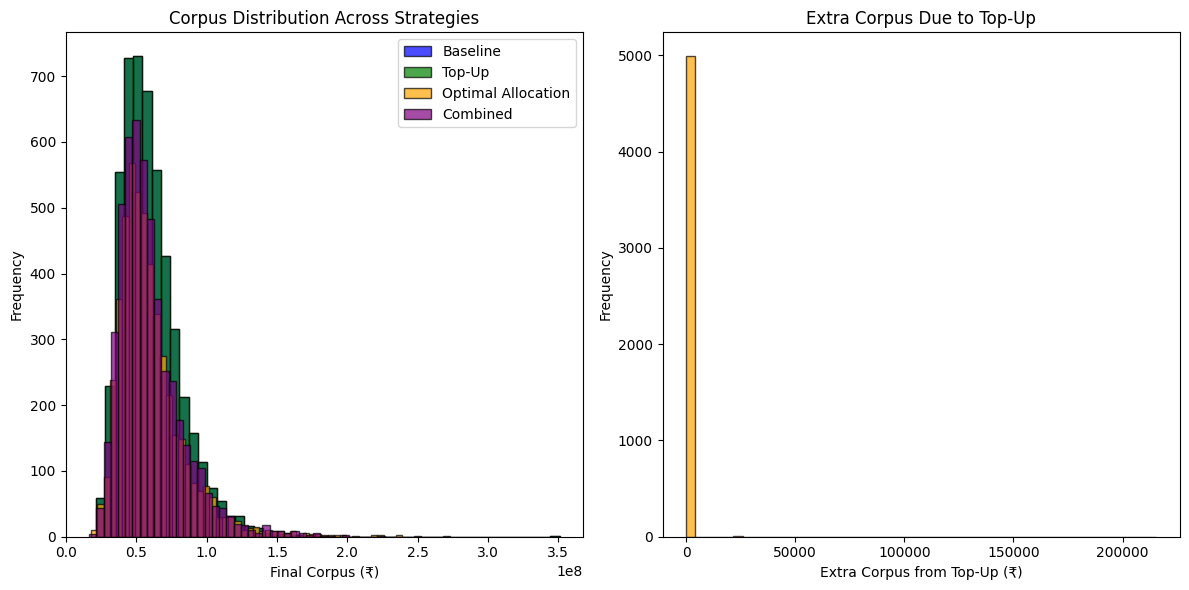

In [4]:
'''we missed using the concept of units uptil now, which impact the results of top-up strategy
here we use units'''

# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulation parameters
years = 30
months = years * 12
monthly_contribution = 10000  # ₹10k per month
annual_increase = 1.1  # 10% yearly increase
top_up_base = 10000  # Base top-up amount
dip_min, dip_max = -0.10, -0.40  # Dynamic dip range (-10% to -40%)
mean_return = 0.005  # Average monthly return (~9.6% annualized)
volatility = 0.10  # Market volatility
simulations = 5000  # Number of Monte Carlo simulations

# Asset classes and NPS limits
assets = ['Equity', 'Corporate Bonds', 'Government Bonds', 'Alternative Assets']
limits = {
    'Equity': (0.20, 0.75),
    'Corporate Bonds': (0.05, 0.40),
    'Government Bonds': (0.05, 0.40),
    'Alternative Assets': (0.00, 0.20)
}
equity_rebalance_threshold = 0.70  # 70% threshold for rebalancing

# Global cooling period variable (in months)
cooling_period = 6

# Initial NAV and Units
initial_nav = 10  # Starting NAV of 10
unit_growth_factor = 1.01  # 1% boost after top-up

# Function to generate random asset allocation within NPS limits
def generate_allocation():
    allocation = {}
    remaining = 1
    for i, asset in enumerate(assets):
        min_limit, max_limit = limits[asset]
        if i == len(assets) - 1:  # Last asset takes remaining allocation
            allocation[asset] = remaining
        else:
            allocation[asset] = np.random.uniform(min_limit, min(max_limit, remaining))
            remaining -= allocation[asset]
    return allocation

# Function to calculate weighted return based on asset allocation
def get_monthly_return(allocation):
    asset_returns = {
        'Equity': np.random.normal(0.01, 0.06),  # Avg 12% annualized with 20% volatility
        'Corporate Bonds': np.random.normal(0.0065, 0.03),  # Avg 8% annualized
        'Government Bonds': np.random.normal(0.0045, 0.02),  # Avg 6% annualized
        'Alternative Assets': np.random.normal(0.0075, 0.04)  # Avg 10% annualized
    }
    return sum(allocation[asset] * asset_returns[asset] for asset in assets)

# Function to rebalance allocation when equity > 70%
def rebalance(allocation):
    total = sum(allocation.values())
    new_allocation = {}
    # Reduce equity to 60% during rebalancing
    new_allocation['Equity'] = min(0.60, allocation['Equity'])
    # Distribute remaining across other assets proportionally
    remaining = 1 - new_allocation['Equity']
    for asset in assets:
        if asset != 'Equity':
            new_allocation[asset] = allocation[asset] / (total - allocation['Equity']) * remaining
    return new_allocation

# Simulation results storage
results_df = pd.DataFrame(columns=["Baseline", "Top-Up", "Optimal Allocation", "Combined"])
topup_log = []  # To log top-up events

# Monte Carlo Simulation
for _ in range(simulations):
    # Reset per simulation variables
    corpus_baseline = corpus_topup = corpus_optimal = corpus_combined = 0
    units_baseline = units_topup = units_optimal = units_combined = 0
    nav_baseline = nav_topup = nav_optimal = nav_combined = initial_nav
    monthly_contribution_dynamic = monthly_contribution
    total_topup = 0
    last_topup_month = -cooling_period  # To allow first top-up if conditions meet

    optimal_allocation = generate_allocation()

    for month in range(months):
        # --- Baseline Strategy ---
        market_return_baseline = get_monthly_return({
            'Equity': 0.50,
            'Corporate Bonds': 0.20,
            'Government Bonds': 0.20,
            'Alternative Assets': 0.10
        })
        nav_baseline *= (1 + market_return_baseline)
        new_units_baseline = monthly_contribution_dynamic / nav_baseline
        units_baseline += new_units_baseline
        corpus_baseline = units_baseline * nav_baseline

        # --- Top-Up Only Strategy ---
        market_return_topup = market_return_baseline  # Same return as baseline
        nav_topup *= (1 + market_return_topup)
        new_units_topup = monthly_contribution_dynamic / nav_topup
        units_topup += new_units_topup
        dip_threshold = np.random.uniform(dip_min, dip_max)

        # Top-Up Check
        if market_return_topup < 0 and market_return_topup < dip_threshold:
            if month - last_topup_month >= cooling_period:
                topup_units = top_up_base / nav_topup
                units_topup += topup_units
                total_topup += top_up_base
                last_topup_month = month
                topup_log.append({
                    "Month": month + 1,
                    "Top-Up Amount": top_up_base,
                    "Units Added": topup_units,
                    "NAV": nav_topup,
                    "Reason": f"Market dip of {market_return_topup:.2%} triggered top-up"
                })
        corpus_topup = units_topup * nav_topup

        # --- Optimal Allocation Strategy ---
        market_return_optimal = get_monthly_return(optimal_allocation)
        nav_optimal *= (1 + market_return_optimal)
        new_units_optimal = monthly_contribution_dynamic / nav_optimal
        units_optimal += new_units_optimal

        # Rebalance Check
        if optimal_allocation['Equity'] > equity_rebalance_threshold:
            optimal_allocation = rebalance(optimal_allocation)

        corpus_optimal = units_optimal * nav_optimal

        # --- Combined Strategy (Top-Up + Optimal Allocation) ---
        market_return_combined = get_monthly_return(optimal_allocation)
        nav_combined *= (1 + market_return_combined)
        new_units_combined = monthly_contribution_dynamic / nav_combined
        units_combined += new_units_combined

        # Combined Top-Up Check
        if market_return_combined < 0 and market_return_combined < dip_threshold:
            if month - last_topup_month >= cooling_period:
                topup_units_combined = top_up_base / nav_combined
                units_combined += topup_units_combined
                total_topup += top_up_base
                last_topup_month = month

        corpus_combined = units_combined * nav_combined

        # --- Annual Contribution Increase ---
        if (month + 1) % 12 == 0:
            monthly_contribution_dynamic *= annual_increase

    # Store simulation results
    results_df = results_df.append({
        "Baseline": corpus_baseline,
        "Top-Up": corpus_topup,
        "Optimal Allocation": corpus_optimal,
        "Combined": corpus_combined
    }, ignore_index=True)

# Calculate mean corpus values
mean_baseline = results_df["Baseline"].mean()
mean_topup = results_df["Top-Up"].mean()
mean_optimal = results_df["Optimal Allocation"].mean()
mean_combined = results_df["Combined"].mean()

# Print final results
print(f"📈 Baseline Corpus: ₹{mean_baseline / 1e7:.2f} Cr")
print(f"💸 Top-Up Only Corpus: ₹{mean_topup / 1e7:.2f} Cr")
print(f"📊 Optimal Allocation Corpus: ₹{mean_optimal / 1e7:.2f} Cr")
print(f"🏆 Combined Strategy Corpus: ₹{mean_combined / 1e7:.2f} Cr")

# Print final NAV values after all simulations
print(f"\nFinal NAVs after {years} years -")
print(f"📈 Baseline: ₹{nav_baseline:.4f}")
print(f"💸 Top-Up: ₹{nav_topup:.4f}")
print(f"📊 Optimal Allocation: ₹{nav_optimal:.4f}")
print(f"🏆 Combined: ₹{nav_combined:.4f}")

print(f"Initial Units - Baseline: {units_baseline:.4f}, Top-Up: {units_topup:.4f}, Optimal Allocation: {units_optimal:.4f}, Combined: {units_combined:.4f}")
# Print final unit values after all simulations
print(f"\nFinal Units after {years} years -")
print(f"📈 Baseline: {units_baseline:.4f} units")
print(f"💸 Top-Up: {units_topup:.4f} units")
print(f"📊 Optimal Allocation: {units_optimal:.4f} units")
print(f"🏆 Combined: {units_combined:.4f} units")

# Print top-up logs (first 5 instances)
print("\n📢 Top-Up Events (First 5 instances):")
for log in topup_log[:5]:
    print(f"Month {log['Month']}: Top-Up of ₹{log['Top-Up Amount']:.2f} added {log['Units Added']:.2f} units at NAV ₹{log['NAV']:.2f} due to {log['Reason']}")

# Visualization
plt.figure(figsize=(12, 6))

# Histogram of Corpus Distribution Across Strategies
plt.subplot(1, 2, 1)
plt.hist(results_df["Baseline"], bins=50, alpha=0.7, color='blue', edgecolor='black', label="Baseline")
plt.hist(results_df["Top-Up"], bins=50, alpha=0.7, color='green', edgecolor='black', label="Top-Up")
plt.hist(results_df["Optimal Allocation"], bins=50, alpha=0.7, color='orange', edgecolor='black', label="Optimal Allocation")
plt.hist(results_df["Combined"], bins=50, alpha=0.7, color='purple', edgecolor='black', label="Combined")
plt.title("Corpus Distribution Across Strategies")
plt.xlabel("Final Corpus (₹)")
plt.ylabel("Frequency")
plt.legend()

# Histogram of Top-Up Impact
plt.subplot(1, 2, 2)
topup_impacts = results_df["Top-Up"] - results_df["Baseline"]
plt.hist(topup_impacts, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title("Extra Corpus Due to Top-Up")
plt.xlabel("Extra Corpus from Top-Up (₹)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


